### <font color="darkblue"><i>A predictive model which tries to predict whether customers will accept a loan offer or not. The model uses only features that will be known at the time of sending an offer. Once the performance metrics of the model have been assessed and the performance (e.g. accuracy) is evaluated to be adequate enough, the model can be used by employees before sending the actual offers. If the model predicts that the offer will not be accepted (i.e. will be refused and/or cancelled) with a high probability, the employee can chose to change the offer and/or not send an offer / send multiple offers. This can reduce the company's overhead/resources in the offer sending process.</i></font>

### <font color="green">imports, preparation and configuration</font>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [38]:
offers = pd.read_table("../data/laraData/offer_events.csv", sep=";")
applications = pd.read_table("../data/laraData/application_events.csv", sep=";")
# all_events = pd.read_table("../data/laraData/events.csv", sep=";") not needed at the moment
applications.head()

,A_ID,A_DT_CREATED,A_INIT_REQ_AMT,A_USER_CREATED,A_APPLICATIONTYPE,A_APPLICATIONTYPE_DESC,A_LOANGOALTYPE,A_LOANGOALTYPE_DESC,AS_ID,AS_APPLICATIONSTATE,...,NUMBER_OF_CHILDREN,MARITAL_STATUS,SEX,HOUSING_TYPE,SCE_CREDITSCORE,SCE_ACCEPTED,SCE_ACCEPTED_OVERRIDE,SCE_MAX_AMOUNT,SCE_MAX_AMOUNT_OVERRIDE,INCOMEAMOUNT_YEAR
0,719696,"1/1/2017 2:42:29,064000",29000.0,USER_1,520,Nieuw krediet,866.0,Auto,1453642,511,...,0.0,Samenwonend,Vrouw,Koophuis,784.0,1.0,1.0,49340.0,49340.0,41088.0
1,719696,"1/1/2017 2:42:29,064000",29000.0,USER_1,520,Nieuw krediet,866.0,Auto,1454067,513,...,0.0,Samenwonend,Vrouw,Koophuis,784.0,1.0,1.0,49340.0,49340.0,41088.0
2,719696,"1/1/2017 2:42:29,064000",29000.0,USER_1,520,Nieuw krediet,866.0,Auto,1458788,517,...,0.0,Samenwonend,Vrouw,Koophuis,784.0,1.0,1.0,49340.0,49340.0,41088.0
3,719696,"1/1/2017 2:42:29,064000",29000.0,USER_1,520,Nieuw krediet,866.0,Auto,1456650,516,...,0.0,Samenwonend,Vrouw,Koophuis,784.0,1.0,1.0,49340.0,49340.0,41088.0
4,719696,"1/1/2017 2:42:29,064000",29000.0,USER_1,520,Nieuw krediet,866.0,Auto,1453643,512,...,0.0,Samenwonend,Vrouw,Koophuis,784.0,1.0,1.0,49340.0,49340.0,41088.0


In [39]:
offers.head()

,A_ID,O_ID,O_SCENARIO,O_DT_CREATED,O_AMOUNT,O_CREDITSCORE,O_FIRST_WITHDRAWL_AMOUNT,NUMBER_OF_TERMS,O_MONTHLY_COST,O_ACCEPTED,...,NUMBER_OF_CHILDREN,MARITAL_STATUS,SEX,HOUSING_TYPE,INCOMEAMOUNT_YEAR,SCE_CREDITSCORE,SCE_ACCEPTED,SCE_ACCEPTED_OVERRIDE,SCE_MAX_AMOUNT,SCE_MAX_AMOUNT_OVERRIDE
0,719696,210708,1367858,"2/1/2017 10:38:26,536000",29000.0,784.0,26604.0,120,29529,1,...,0,Samenwonend,Vrouw,Koophuis,41088.0,784.0,1.0,1.0,49340.0,49340.0
1,719696,210708,1367858,"2/1/2017 10:38:26,536000",29000.0,784.0,26604.0,120,29529,1,...,0,Samenwonend,Vrouw,Koophuis,41088.0,784.0,1.0,1.0,49340.0,49340.0
2,719696,210708,1367858,"2/1/2017 10:38:26,536000",29000.0,784.0,26604.0,120,29529,1,...,0,Samenwonend,Vrouw,Koophuis,41088.0,784.0,1.0,1.0,49340.0,49340.0
3,719696,210708,1367858,"2/1/2017 10:38:26,536000",29000.0,784.0,26604.0,120,29529,1,...,0,Samenwonend,Vrouw,Koophuis,41088.0,784.0,1.0,1.0,49340.0,49340.0
4,719697,210793,1367861,"2/1/2017 16:08:07,608000",10000.0,NaN,10000.0,44,24958,1,...,0,Alleenstaand,Man,Thuiswonend/ Inwonend,21600.0,708.0,1.0,1.0,235875.0,235875.0


O_SELECTED tells us whetehr an offer is accepted(1)/or refused/cancelled (0)

In [40]:
made_offers = offers[pd.notnull(offers.O_SELECTED)]
made_offers.shape

(118931, 30)

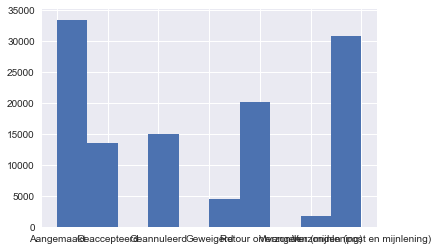

In [41]:
made_offers.OS_OFFERSTATE_DESC.hist()

In [7]:
len(made_offers.O_ID.unique())

33401

In [81]:
cancelled = made_offers.copy()

In [44]:
are_cancelled = cancelled[cancelled.event == 'O_Cancelled'].O_ID.unique()

array([210793, 210794, 210961, ..., 244653, 244754, 244965], dtype=int64)

In [57]:
import math

In [82]:
cancelled["is_cancelled"] = np.nan
cancelled["is_cancelled"] = cancelled[cancelled.O_ID.isin(are_cancelled)]
cancelled.loc[(cancelled['is_cancelled'] > 0), 'is_cancelled'] = True
cancelled[['is_cancelled']] = cancelled[['is_cancelled']].fillna(value = False)

,A_ID,O_ID,O_SCENARIO,O_DT_CREATED,O_AMOUNT,O_CREDITSCORE,O_FIRST_WITHDRAWL_AMOUNT,NUMBER_OF_TERMS,O_MONTHLY_COST,O_ACCEPTED,...,MARITAL_STATUS,SEX,HOUSING_TYPE,INCOMEAMOUNT_YEAR,SCE_CREDITSCORE,SCE_ACCEPTED,SCE_ACCEPTED_OVERRIDE,SCE_MAX_AMOUNT,SCE_MAX_AMOUNT_OVERRIDE,is_cancelled
0,719696,210708,1367858,"2/1/2017 10:38:26,536000",29000.0,784.0,26604.0,120,29529,1,...,Samenwonend,Vrouw,Koophuis,41088.0,784.0,1.0,1.0,49340.0,49340.0,False
1,719696,210708,1367858,"2/1/2017 10:38:26,536000",29000.0,784.0,26604.0,120,29529,1,...,Samenwonend,Vrouw,Koophuis,41088.0,784.0,1.0,1.0,49340.0,49340.0,False
2,719696,210708,1367858,"2/1/2017 10:38:26,536000",29000.0,784.0,26604.0,120,29529,1,...,Samenwonend,Vrouw,Koophuis,41088.0,784.0,1.0,1.0,49340.0,49340.0,False
3,719696,210708,1367858,"2/1/2017 10:38:26,536000",29000.0,784.0,26604.0,120,29529,1,...,Samenwonend,Vrouw,Koophuis,41088.0,784.0,1.0,1.0,49340.0,49340.0,False
4,719697,210793,1367861,"2/1/2017 16:08:07,608000",10000.0,NaN,10000.0,44,24958,1,...,Alleenstaand,Man,Thuiswonend/ Inwonend,21600.0,708.0,1.0,1.0,235875.0,235875.0,True
5,719697,210794,1367861,"2/1/2017 16:09:04,325000",13000.0,NaN,13000.0,57,25717,0,...,Alleenstaand,Man,Thuiswonend/ Inwonend,21600.0,708.0,1.0,1.0,235875.0,235875.0,True
6,719697,210794,1367861,"2/1/2017 16:09:04,325000",13000.0,NaN,13000.0,57,25717,0,...,Alleenstaand,Man,Thuiswonend/ Inwonend,21600.0,708.0,1.0,1.0,235875.0,235875.0,True
7,719697,210793,1367861,"2/1/2017 16:08:07,608000",10000.0,NaN,10000.0,44,24958,1,...,Alleenstaand,Man,Thuiswonend/ Inwonend,21600.0,708.0,1.0,1.0,235875.0,235875.0,True
8,719697,210794,1367861,"2/1/2017 16:09:04,325000",13000.0,NaN,13000.0,57,25717,0,...,Alleenstaand,Man,Thuiswonend/ Inwonend,21600.0,708.0,1.0,1.0,235875.0,235875.0,True
9,719697,210793,1367861,"2/1/2017 16:08:07,608000",10000.0,NaN,10000.0,44,24958,1,...,Alleenstaand,Man,Thuiswonend/ Inwonend,21600.0,708.0,1.0,1.0,235875.0,235875.0,True


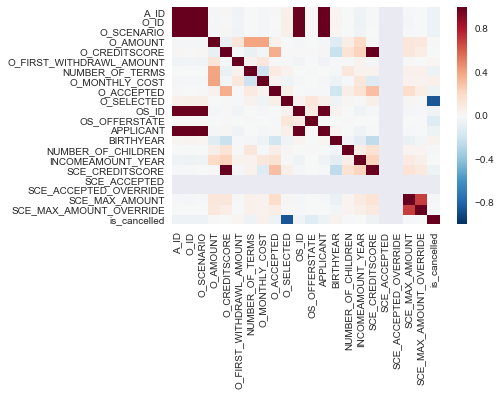

In [83]:
corr = cancelled.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [9]:
len(cancelled[cancelled.O_SELECTED == 1]) / len(cancelled.O_SELECTED == 0)

0.07467380394780863

In [10]:
cancelled.O_ID.unique()

array([210793, 210794, 210961, ..., 244653, 244754, 244965], dtype=int64)

In [11]:
made_offers = (made_offers.loc[(made_offers.event == "O_Accepted") 
                | (made_offers.event == "O_Refused")])

In [12]:
len(made_offers.O_ID.unique()), made_offers.shape

(18102, (18102, 30))

In [13]:
made_offers.head()

,A_ID,O_ID,O_SCENARIO,O_DT_CREATED,O_AMOUNT,O_CREDITSCORE,O_FIRST_WITHDRAWL_AMOUNT,NUMBER_OF_TERMS,O_MONTHLY_COST,O_ACCEPTED,...,NUMBER_OF_CHILDREN,MARITAL_STATUS,SEX,HOUSING_TYPE,INCOMEAMOUNT_YEAR,SCE_CREDITSCORE,SCE_ACCEPTED,SCE_ACCEPTED_OVERRIDE,SCE_MAX_AMOUNT,SCE_MAX_AMOUNT_OVERRIDE
0,719696,210708,1367858,"2/1/2017 10:38:26,536000",29000.0,784.0,26604.0,120,29529,1,...,0,Samenwonend,Vrouw,Koophuis,41088.0,784.0,1.0,1.0,49340.0,49340.0
15,719699,210814,1367869,"2/1/2017 17:22:18,492000",5000.0,719.0,175503.0,60,974,1,...,0,Alleenstaand,Vrouw,Huurhuis / Kamers,18000.0,719.0,1.0,1.0,58375.0,58375.0
23,719701,211658,1367878,"9/1/2017 15:32:34,085000",22000.0,776.0,22000.0,120,22603,0,...,0,Alleenstaand,Man,Huurhuis / Kamers,27330.0,776.0,1.0,1.0,324765.0,33778.0
29,719702,210833,1367880,"2/1/2017 19:42:25,280000",13000.0,NaN,3500.0,134,130,0,...,0,Alleenstaand,Man,Thuiswonend/ Inwonend,19224.0,683.0,1.0,1.0,151725.0,151725.0
35,719705,210832,1367893,"2/1/2017 19:42:21,339000",10500.0,982.0,10500.0,60,19853,1,...,0,Gehuwd,Vrouw,Koophuis,48282.0,982.0,1.0,1.0,791635.0,81545.0


Features that are going to be considered:
* Marital status (e.g. married, single, divorced, widowed)
* Housing type (e.g. owner occupied property, rental property etc)
* Yearly income amount (yearly) (if married and/or living together: yearly income of partners)
* Number of children 
* Sex (Male, Female)
* Age (2017 - birthyear)
* <b>O_Amount</b> (offered amount by bank; does not need to be equal to request amount by applicant (but this is often the case))
* <b>Number of terms</b> (relevant to the applicant)
* <b>Monthly cost</b> (relevant to the applicant)
* Percentage offered amount of year income (amount / year_income) * 100 
* Percentage yearly cost (12 * monthly cost) of year income
* Difference between offered amount and inital requested amount

The attributes that are made bold, are attributes which the bank can vary from offer to offer (i.e. the variables of the offer). Other attributes have a relation to these attributes (e.g. last three attributes), while the other attributes is simply customer data. The hypothesis is that there are differences between (groups) of customers in the cognitive mechanisms behind the decision making process when faced with an offer.

Construct age attribute from the applicant's birthyear 

In [14]:
made_offers["age"]= 2017 - made_offers.BIRTHYEAR

Percentage offered amount of year income ((offered_amount / year_income) * 100)

In [15]:
made_offers["percentage_amount_income"] = (made_offers.O_AMOUNT / made_offers.INCOMEAMOUNT_YEAR) * 100

Percentage yearly cost (12 * monthly cost) of year income

In [16]:
made_offers["percentage_cost_income"] = ((made_offers.O_MONTHLY_COST * 12) / made_offers.INCOMEAMOUNT_YEAR) * 100

Enrich offer data with application data (e.g. the applicant's initial requested amount , the application type (e.g. new credit, raise limit) and application loan goal (e.g. car, homeimprovements etc.)

In [17]:
unique_applications = applications.drop_duplicates(subset = 'A_ID')
unique_applications = unique_applications[['A_ID', 'A_INIT_REQ_AMT', 'A_APPLICATIONTYPE_DESC', 'A_LOANGOALTYPE_DESC']]
unique_applications.head()

,A_ID,A_INIT_REQ_AMT,A_APPLICATIONTYPE_DESC,A_LOANGOALTYPE_DESC
0,719696,29000.0,Nieuw krediet,Auto
8,719697,10000.0,Nieuw krediet,Auto
13,719698,15000.0,Nieuw krediet,Woningverbetering
18,719699,5000.0,Nieuw krediet,Overname lopende leningen
29,719700,5000.0,Nieuw krediet,Niet gespecificeerd


Enrich offer data with initial requested amount (not necesarilly equal to offered amount), application type and loan goal

In [18]:
made_offers = made_offers.merge(unique_applications, on = "A_ID")

Calculate the difference between the offered amount and the initial requested amount

In [19]:
made_offers["diff_req_and_offered_amount"] = abs(made_offers.A_INIT_REQ_AMT - made_offers.O_AMOUNT)

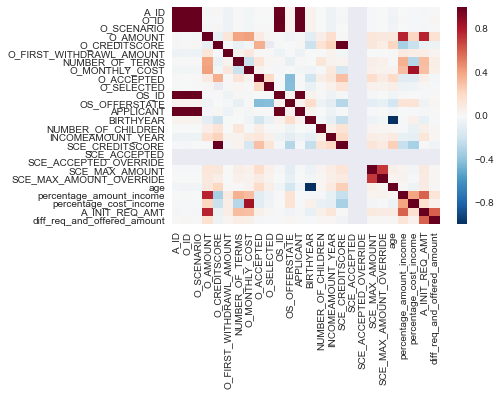

In [20]:
corr = made_offers.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### <font color="green">Configure classification model</font>

Target attribute (i.e. label): O_SELECTED

In [21]:
req_amount = tf.feature_column.numeric_column('A_INIT_REQ_AMT')
income = tf.feature_column.numeric_column('INCOMEAMOUNT_YEAR')
number_of_children = tf.feature_column.numeric_column('NUMBER_OF_CHILDREN')
age = tf.feature_column.numeric_column('age')
o_amount = tf.feature_column.numeric_column('O_AMOUNT')
number_of_terms = tf.feature_column.numeric_column('NUMBER_OF_TERMS')
monthly_cost = tf.feature_column.numeric_column('O_MONTHLY_COST')
per_amount_income = tf.feature_column.numeric_column('percentage_amount_income')
per_cost_income = tf.feature_column.numeric_column('percentage_cost_income')
diff_req_and_offered_amount = tf.feature_column.numeric_column("diff_req_and_offered_amount")

In [22]:
made_offers.A_APPLICATIONTYPE_DESC.unique()

array(['Nieuw krediet', 'Limietverhoging'], dtype=object)

In [23]:
made_offers.A_LOANGOALTYPE_DESC.unique()

array(['Auto', 'Overname lopende leningen', 'Woningverbetering',
       'Anders, zie toelichting', nan, 'Extra Bestedingsruimte',
       'Restschuld woning', 'Niet gespecificeerd', 'Boot',
       'Tourcaravan / camper', 'Motor', 'Belastingbetalingen',
       'Zakelijk doel (no go)', 'Verbouwing aan het huis',
       'verbouwing meubels/interieur', 'Verbouwing aan tuin',
       'Onderhandse lening'], dtype=object)

In [24]:
made_offers.HOUSING_TYPE.unique()

array(['Koophuis', 'Huurhuis / Kamers', 'Thuiswonend/ Inwonend'], dtype=object)

In [25]:
made_offers.MARITAL_STATUS.unique()

array(['Samenwonend', 'Alleenstaand', 'Gehuwd',
       'Geregistreerd partnerschap'], dtype=object)

In [26]:
loanGoal = tf.feature_column.categorical_column_with_vocabulary_list('A_LOANGOALTYPE_DESC',
                                                                           ['Auto', 'Woningverbetering', 'Overname lopende leningen',
                                                                            'Tourcaravan / camper', 'Anders, zie toelichting', 'nan',
                                                                            'Extra Bestedingsruimte', 'Niet gespecificeerd',
                                                                            'Restschuld woning', 'Boot', 'Motor', 'Belastingbetalingen',
                                                                            'Zakelijk doel (no go)', 'Schuldsanering (no go)',
                                                                            'Verbouwing aan het huis', 'verbouwing meubels/interieur',
                                                                            'Verbouwing aan tuin', 'Zakelijk pand (no go)', 'Onderhandse lening'])
applicationType = tf.feature_column.categorical_column_with_vocabulary_list('A_APPLICATIONTYPE_DESC',
                                                                           ['Nieuw krediet', 'Limietverhoging'])
housingType = tf.feature_column.categorical_column_with_vocabulary_list('HOUSING_TYPE',
                                                                          ['Koophuis', 'Thuiswonend/ Inwonend', 'Huurhuis / Kamers'])
gender = tf.feature_column.categorical_column_with_vocabulary_list('SEX', ['Man', 'Vrouw'])
marital_status = tf.feature_column.categorical_column_with_vocabulary_list('MARITAL_STATUS', ['Samenwonend', 'Alleenstaand',
                                                                                              'Gehuwd', 'Geregistreerd partnerschap'])

In [27]:
made_offers = made_offers[['NUMBER_OF_CHILDREN','NUMBER_OF_TERMS',
                           'O_MONTHLY_COST', 'percentage_amount_income', 'percentage_cost_income', 'MARITAL_STATUS',
                          "diff_req_and_offered_amount", 'A_LOANGOALTYPE_DESC', 'A_APPLICATIONTYPE_DESC',
                           'SEX', 'O_SELECTED']]
made_offers = made_offers.dropna(how = "any")
made_offers.shape

(16889, 11)

In [28]:
made_offers = made_offers.apply(preprocessing.LabelEncoder().fit_transform)

In [29]:
x_features = made_offers.drop('O_SELECTED', axis = 1)

In [30]:
pred_labels = made_offers['O_SELECTED']
pred_labels = preprocessing.LabelEncoder().fit_transform(pred_labels)

In [31]:
feat_cols = [tf.contrib.layers.real_valued_column("", dimension= x_features.shape[1])]

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x_features.as_matrix(), pred_labels, test_size = 0.2, random_state = 700)

In [33]:
classifier = tf.contrib.learn.DNNClassifier(feature_columns = feat_cols, hidden_units= [64, 32, 16],
                                            n_classes = 2, model_dir  ="tf_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001BFCA87BF98>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'tf_model'}


In [34]:
pipe_tf = Pipeline([('std_scl', preprocessing.StandardScaler()), ('dnn', classifier)])

In [35]:
pipe_tf.fit(x_train, y_train, dnn__steps = 2000)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tf_model\model.ckpt.
INFO:tensorflow:loss = 0.694185, step = 1
INFO:tensorflow:global_step/sec: 22.7403
INFO:tensorflow:loss = 0.206928, step = 101 (4.398 sec)
INFO:tensorflow:global_step/sec: 26.3775
INFO:tensorflow:loss = 0.203174, step = 201 (3.790 sec)
INFO:tensorflow:global_step/sec: 26.7065
INFO:tensorflow:loss = 0.201005, step = 301 (3.745 sec)
INFO:tensorflow:global_step/sec: 27.4506
INFO:tensorflow:loss = 0.199459, step = 401 (3.643 sec)
INFO:tensorflow:global_step/sec: 25.7964
INFO:tensorflow:loss = 0.198219, step = 501 (3.877 sec)
INFO:tensorflow:global_step/sec: 

Pipeline(steps=[('std_scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dnn', DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x000001BFCA843A58>, 'hidden_units': [64, 32, 16], 'feature_columns': (_RealValuedColumn(column_nam...'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None}))])

In [36]:
score = metrics.accuracy_score(y_test, list(pipe_tf.predict(x_test)))
print('Accuracy: {0:f}'.format(score))

Instructions for updating:
Please switch to predict_classes, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


INFO:tensorflow:Restoring parameters from tf_model\model.ckpt-2000
Accuracy: 0.933985
